In [1]:
from __future__ import print_function
import roslib
import rosbag
import rospy
import cv2
import os
import numpy as np
from sensor_msgs.msg import Image
from cv_bridge import CvBridge, CvBridgeError
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras
from matplotlib import pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
for bag in glob("datasets/dataset002/*.bag"):
    bag_name = bag.split('/')[1].split(".")[0]
    with rosbag.Bag(bag, 'r') as inbag:
        for topic, msg, t in tqdm(inbag.read_messages()):
            if topic == '/scan':
                print(msg)
                break

0it [00:00, ?it/s]
0it [00:00, ?it/s]

header: 
  seq: 8282
  stamp: 
    secs: 1529529894
    nsecs:  44362982
  frame_id: "laser"
angle_min: -2.35619449615
angle_max: 2.35619449615
angle_increment: 0.00436332309619
time_increment: 1.73611151695e-05
scan_time: 0.0250000003725
range_min: 0.019999999553
range_max: 30.0
ranges: [1.2640000581741333, 1.2699999809265137, 1.284999966621399, 1.2920000553131104, 1.2990000247955322, 1.3029999732971191, 1.3029999732971191, 1.2480000257492065, 1.2230000495910645, 1.2029999494552612, 1.187999963760376, 1.1699999570846558, 1.152999997138977, 1.1480000019073486, 1.1269999742507935, 1.128999948501587, 1.1080000400543213, 1.0820000171661377, 1.0870000123977661, 1.0740000009536743, 1.069000005722046, 1.0700000524520874, 1.0429999828338623, 1.0410000085830688, 1.0460000038146973, 1.0130000114440918, 0.9860000014305115, 0.7710000276565552, 0.7289999723434448, 0.6959999799728394, 0.6899999976158142, 0.7099999785423279, 0.734000027179718, 0.7559999823570251, 0.7099999785423279, 0.68900001049041

In [3]:
scans = []
steering_in = []
steering_out = []
throttle_in = []
throttle_out = []

last_st_in = None
last_st_out = None
last_th_in = None
last_th_out = None

for bag in glob("datasets/dataset002/*.bag"):
    bag_name = bag.split('/')[1].split(".")[0]
    with rosbag.Bag(bag, 'r') as inbag:
        for topic, msg, t in tqdm(inbag.read_messages()):
            if topic == '/scan':
                if last_st_in is not None and last_st_out is not None:
                    steering_in.append(last_st_in)
                    throttle_in.append(last_th_in)
                    steering_out.append(last_st_out)
                    throttle_out.append(last_th_out)
                    scans.append(np.array(msg.ranges))
            if topic == '/mavros/rc/in':
                last_st_in = msg.channels[0]
                last_th_in = msg.channels[2]
            if topic == '/mavros/rc/out':
                last_st_out = msg.channels[0]
                last_th_out = msg.channels[2]


15898it [00:01, 12861.55it/s]
15573it [00:01, 13028.98it/s]


In [4]:
scans = np.array(scans)
steering_in = np.array(steering_in)
steering_out = np.array(steering_out)
throttle_in = np.array(throttle_in)
throttle_out = np.array(throttle_out)

In [5]:
print("Scans shape:", scans.shape)
print("Steering in/out shape: %s/%s" % (steering_in.shape, steering_out.shape))
print("Throttle in/out shape: %s/%s" % (throttle_in.shape, throttle_out.shape))


Scans shape: (18217, 1081)
Steering in/out shape: (18217,)/(18217,)
Throttle in/out shape: (18217,)/(18217,)


In [6]:
np.arange(-2.35619449615, 2.35619449615, 0.00436332309619).shape

(1081,)

1350


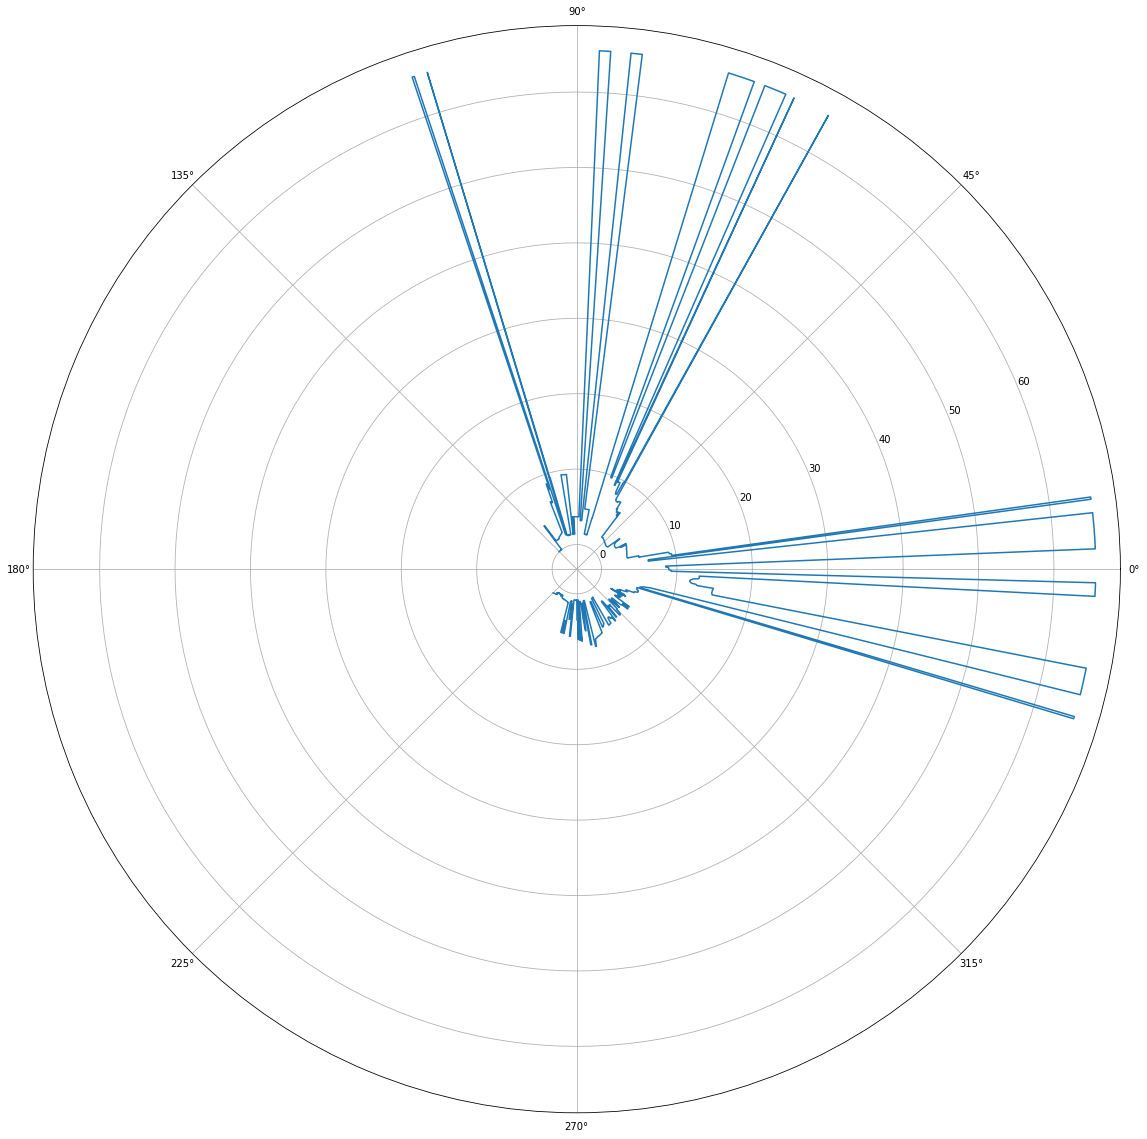

In [7]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1, polar=True)

r = np.arange(-2.35619449615, 2.35619449615, 0.00436332309619)

ax.plot(r,scans[0])
print(steering_in[0])

plt.show();

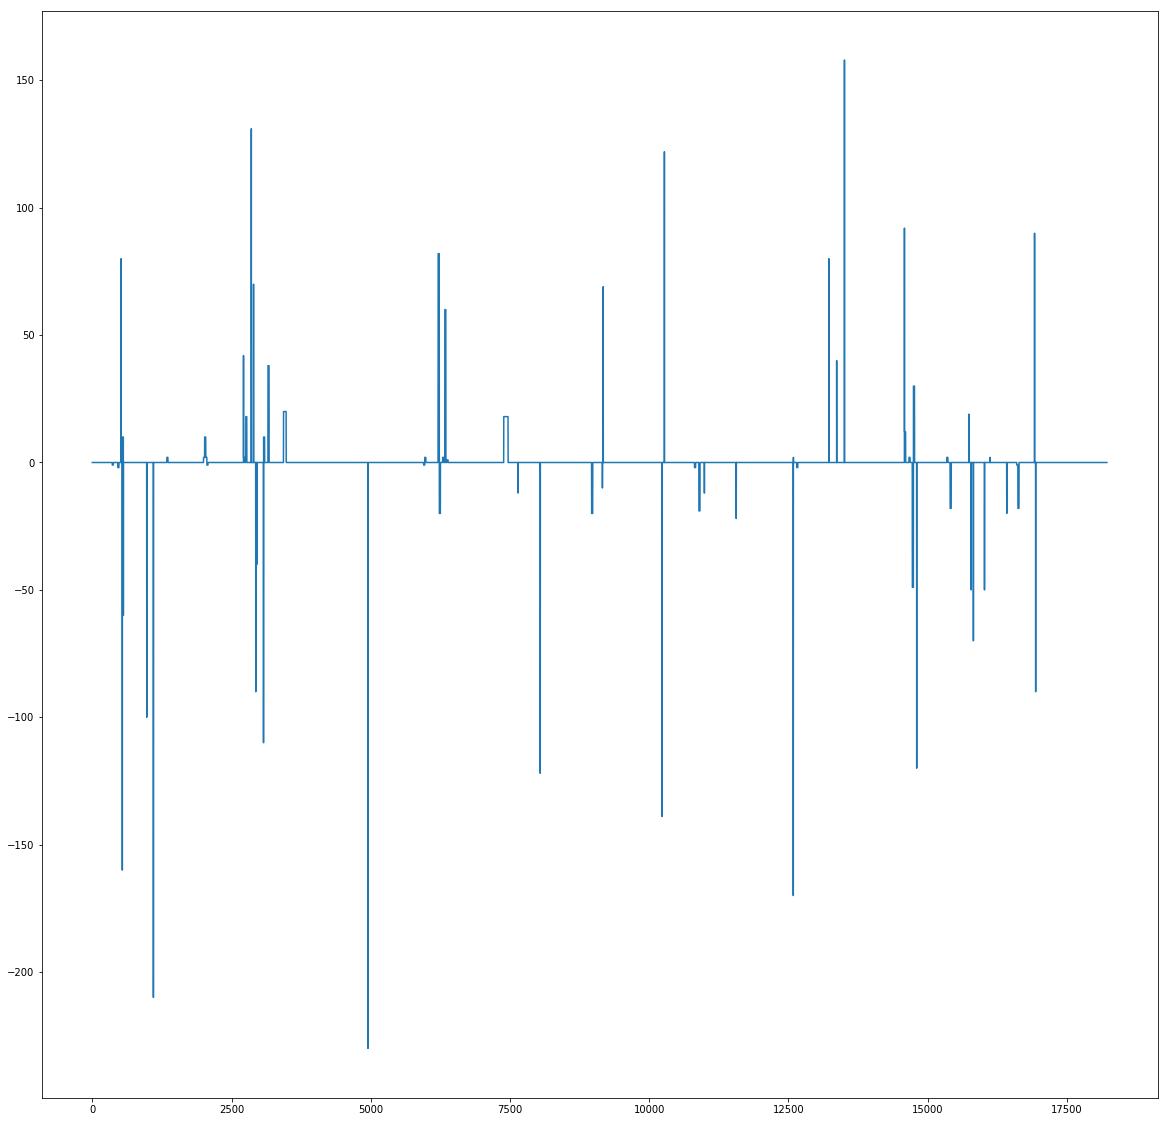

In [8]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)

ax.plot(steering_in-steering_out)

plt.show();

In [9]:
def processAngle(angle):
    return (angle - 800.0) / (1800.0-800.0) - 0.5

def originalAngle(angle):
    return (angle + 0.5) * (1800.0-800.0) + 800.0

def processScan(scan):
    return scan / 65.5

def originalScan(scan):
    return scan * 65.5


0.004000000189989805
65.53299713134766


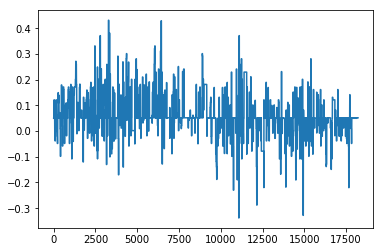

In [10]:
processed_angles = processAngle(steering_in)
processed_scanes = processScan(scans)

print(np.min(scans))
print(np.max(scans))

plt.plot(processed_angles)
plt.show();

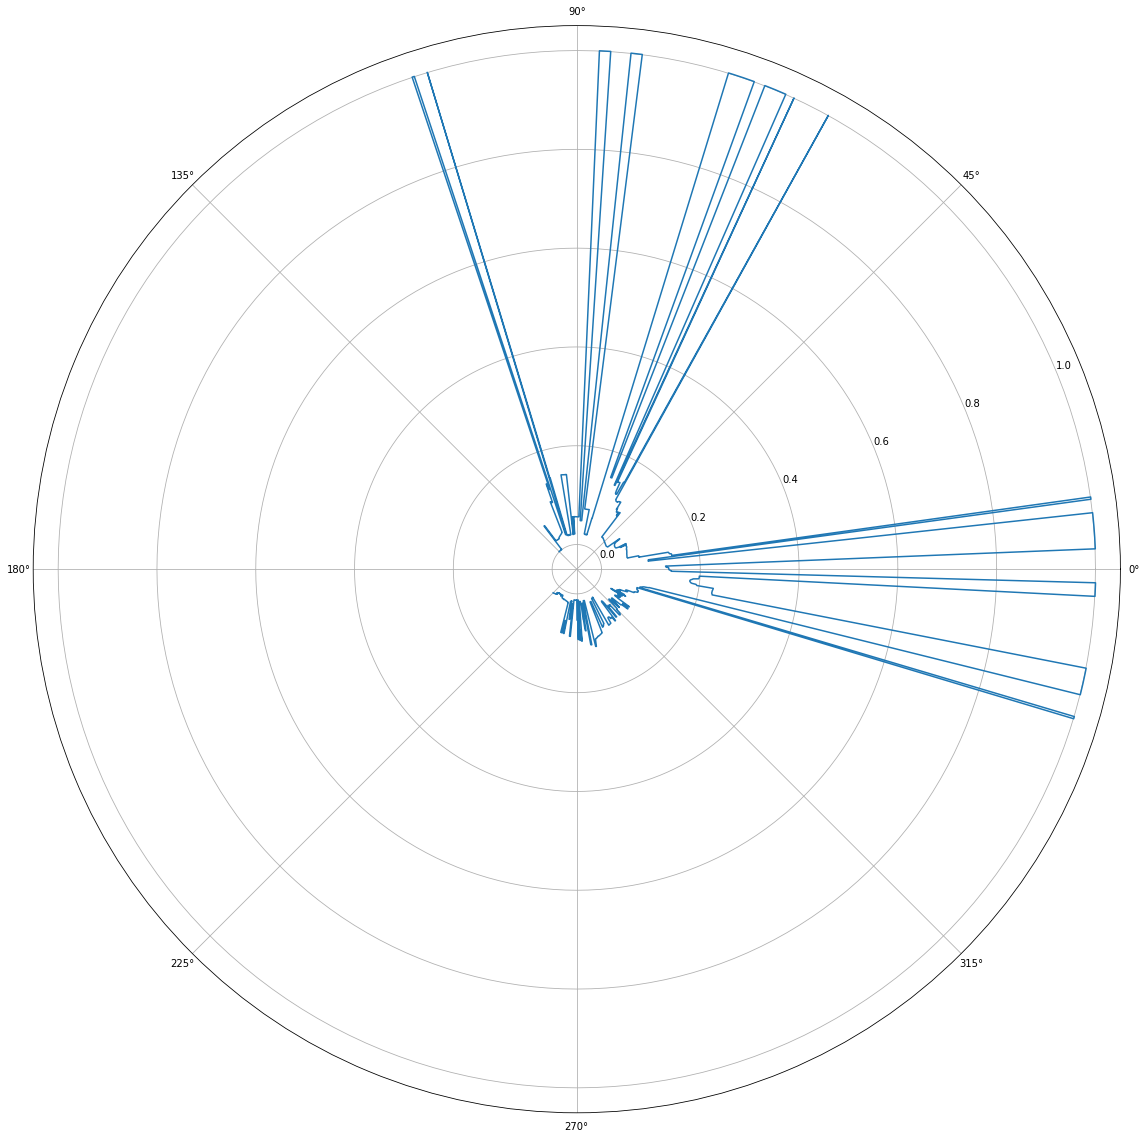

In [11]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1, polar=True)

r = np.arange(-2.35619449615, 2.35619449615, 0.00436332309619)

ax.plot(r,processed_scanes[0])

plt.show();

In [12]:
X_train, X_test, y_train, y_test = train_test_split(processed_scanes, processed_angles, test_size=0.1, random_state=42)

In [13]:
print("Train X,y:",X_train.shape, y_train.shape)
print("Test  X,y:",X_test.shape, y_test.shape)

Train X,y: (16395, 1081) (16395,)
Test  X,y: (1822, 1081) (1822,)


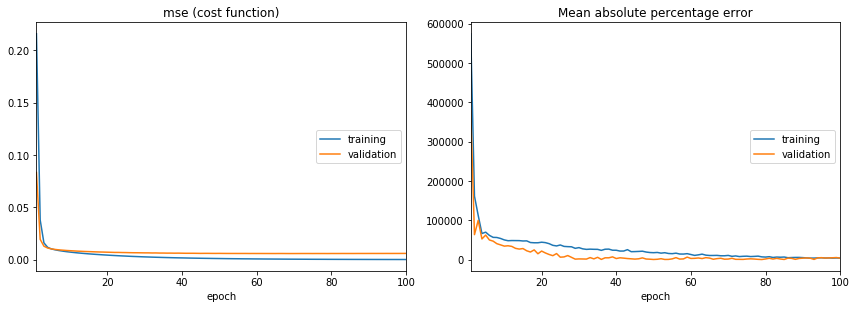

In [14]:
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
model.fit(X_train, y_train, batch_size=1024, epochs=100,
          callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/512_not_uniform_1'),PlotLossesKeras()],
          validation_split=0.1, shuffle=True)

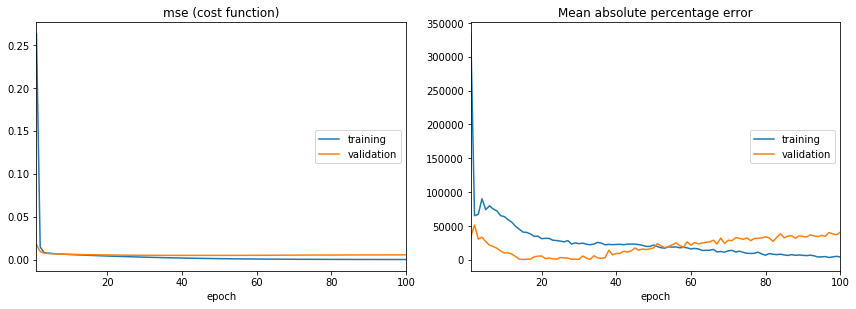

In [15]:
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
model.fit(X_train, y_train, batch_size=1024, epochs=100,
          callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/512_512_not_uniform_1'), PlotLossesKeras()],
          validation_split=0.1, shuffle=True)

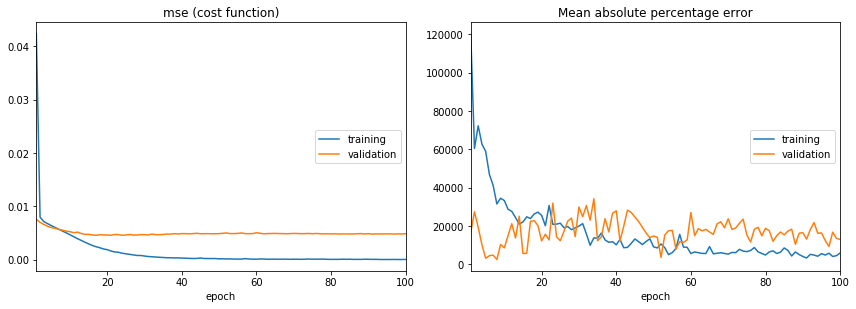

In [16]:
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dense(512, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform'))
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
model.fit(X_train, y_train, batch_size=1024, epochs=100,
          callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/512_512_1'), PlotLossesKeras()],
          validation_split=0.1, shuffle=True)

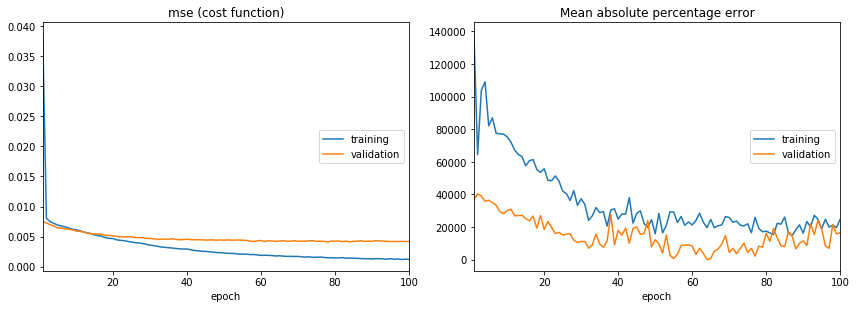

In [17]:
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform'))
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
model.fit(X_train, y_train, batch_size=1024, epochs=100, 
          callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/512_0.5_512_1'), PlotLossesKeras()], 
          validation_split=0.1, shuffle=True)

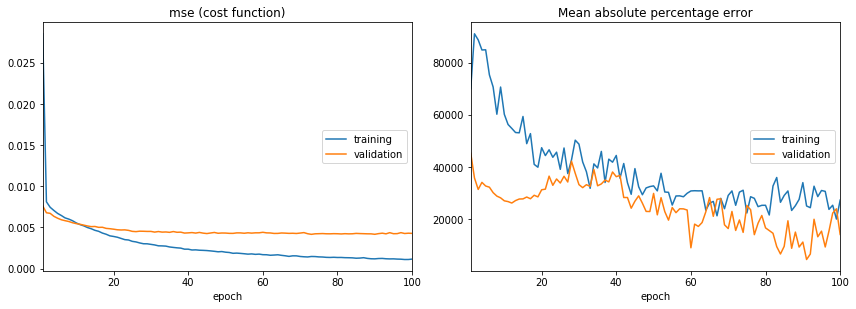

In [18]:
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, init='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, init='uniform'))
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
model.fit(X_train, y_train, batch_size=1024, epochs=100,
          callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/512_0.5_512_0.5_1'), PlotLossesKeras()],
          validation_split=0.1, shuffle=True)

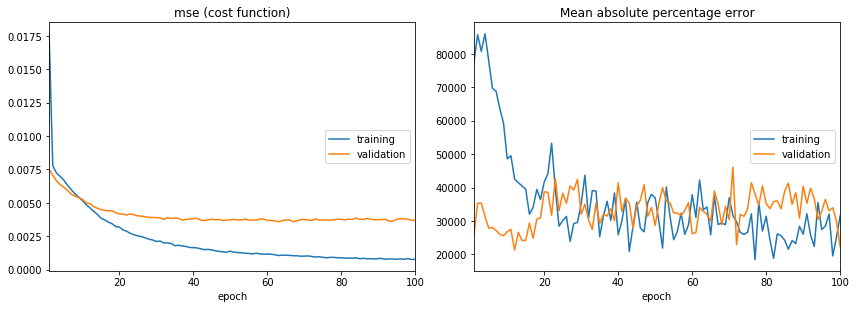

In [19]:
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform'))
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
model.fit(X_train, y_train, batch_size=1024, epochs=100,
          callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/512_0.5_512_0.3_512_1'), PlotLossesKeras()],
          validation_split=0.1, shuffle=True)

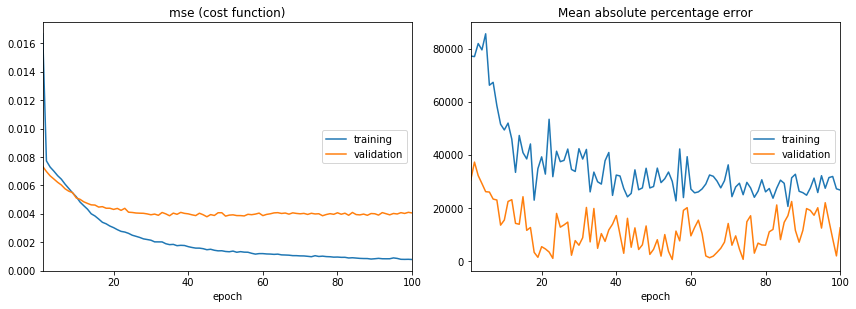

In [20]:
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, init='uniform'))
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
model.fit(X_train, y_train, batch_size=1024, epochs=100,
          callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/512_0.5_512_0.3_512_0.3_1'), PlotLossesKeras()],
          validation_split=0.1, shuffle=True)

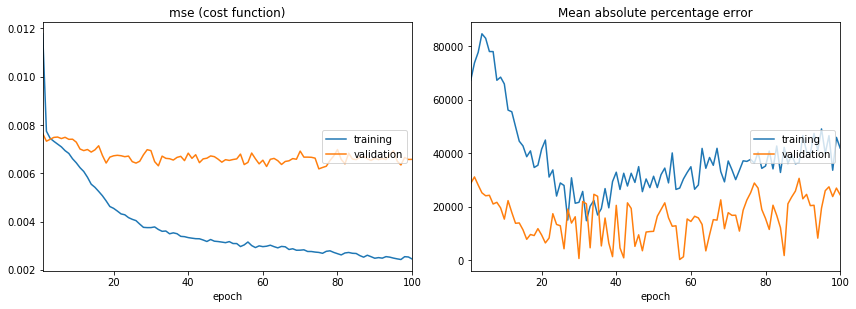

In [21]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
model.fit(X_train, y_train, batch_size=1024, epochs=100,
          callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/Mega_128_0.3_1'), PlotLossesKeras()],
          validation_split=0.1, shuffle=True)

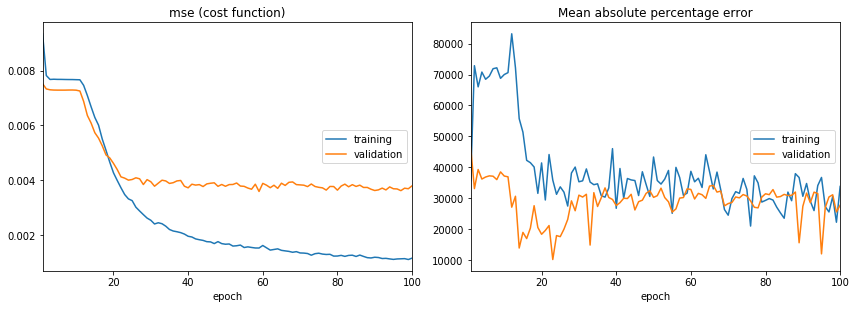

In [14]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, init='uniform'))
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
model.fit(X_train, y_train, batch_size=1024, epochs=100,
          callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/Mega_128_0.3_uniform_1'),PlotLossesKeras()],
          validation_split=0.1, shuffle=True)

In [15]:
# calculate predictions
predictions = model.predict(X_test)

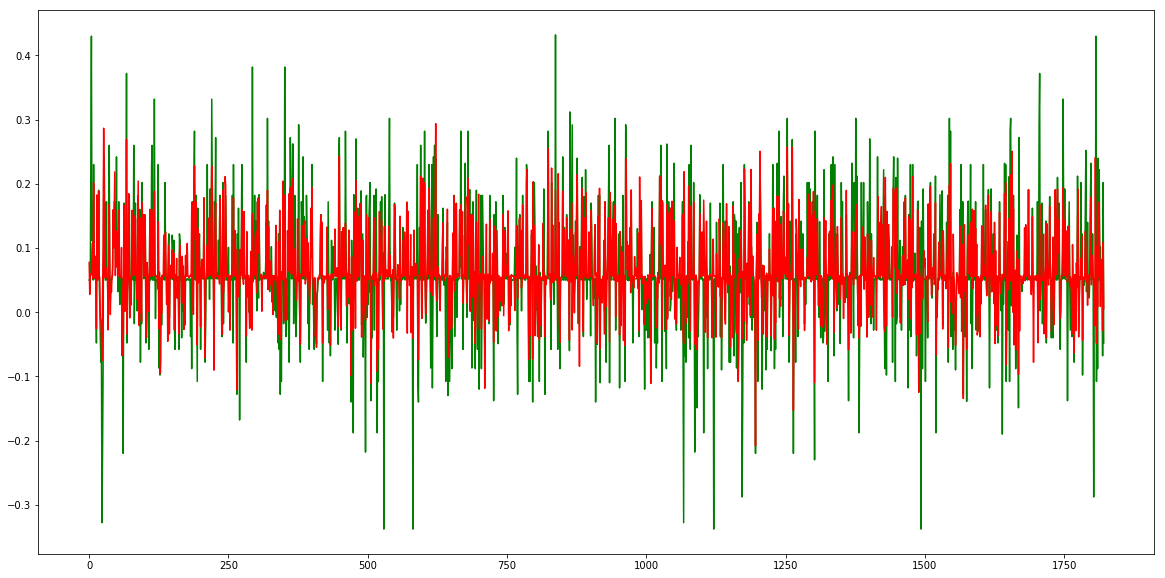

In [16]:
fig = plt.figure(figsize=(20,10))
plt.plot(y_test, 'g', predictions,'r');

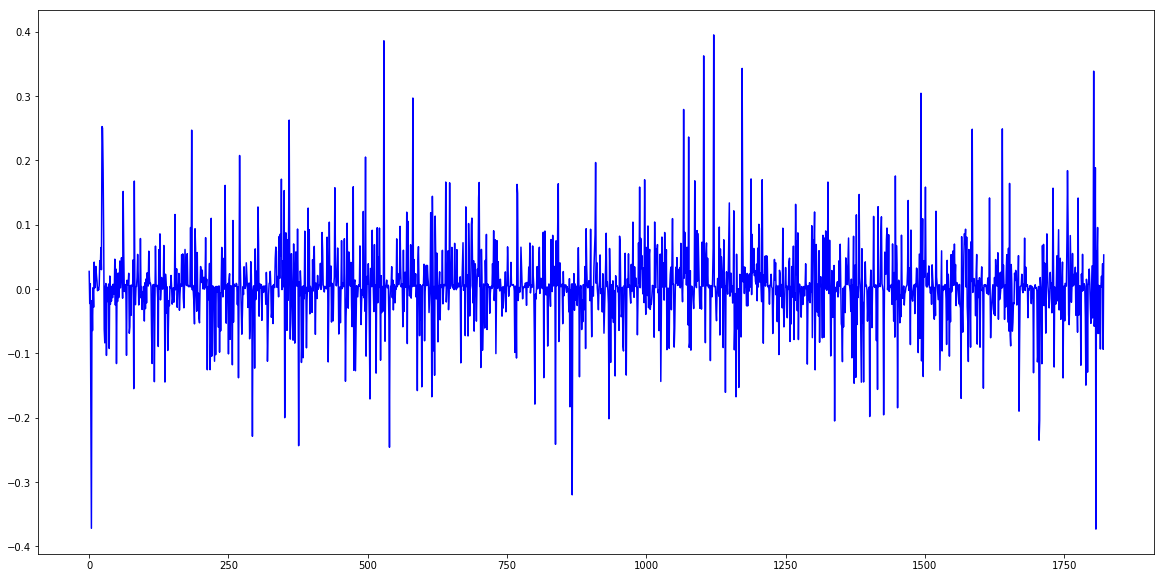

In [20]:
predictions = predictions.reshape(-1)
fig = plt.figure(figsize=(20,10))
plt.plot(predictions - y_test, 'b');

In [31]:
print(X_train.shape)
X_train2 = np.concatenate((X_train, X_train[:,::-1]))
print(X_train2.shape)
y_train2 = np.concatenate((y_train, 0.11 - y_train))

(16395, 1081)
(32790, 1081)


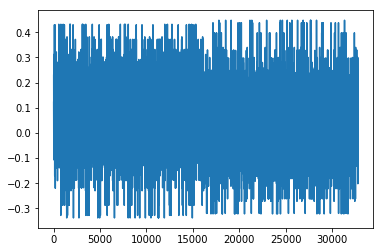

In [32]:
plt.plot(y_train2);

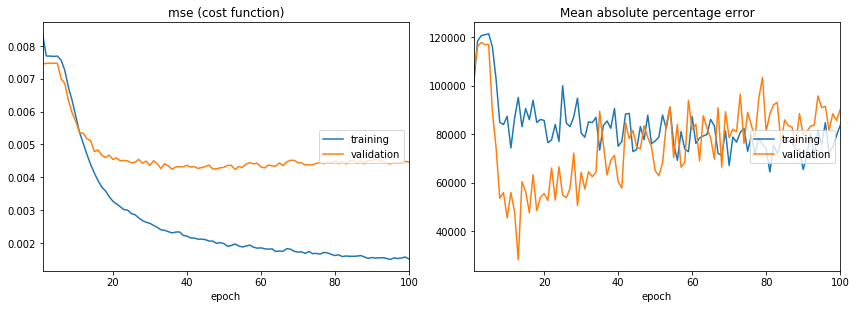

In [33]:
model = Sequential()
model.add(Dense(128, input_dim=X_train2.shape[1], init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, init='uniform'))
model.compile(loss='mse', optimizer='adam', metrics=['mape'])
model.fit(X_train2, y_train2, batch_size=1024, epochs=100,
          callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/Mega_128_0.3_uniform_1_train2_0.1'),PlotLossesKeras()],
          validation_split=0.1, shuffle=True)

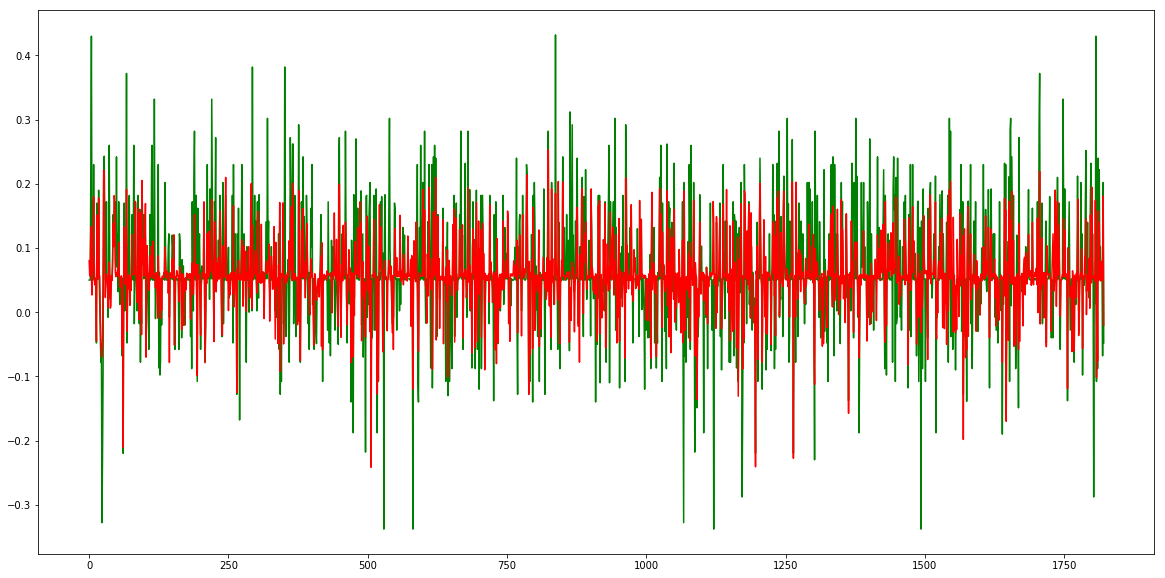

In [34]:
# calculate predictions
predictions = model.predict(X_test)

fig = plt.figure(figsize=(20,10))
plt.plot(y_test, 'g', predictions,'r');

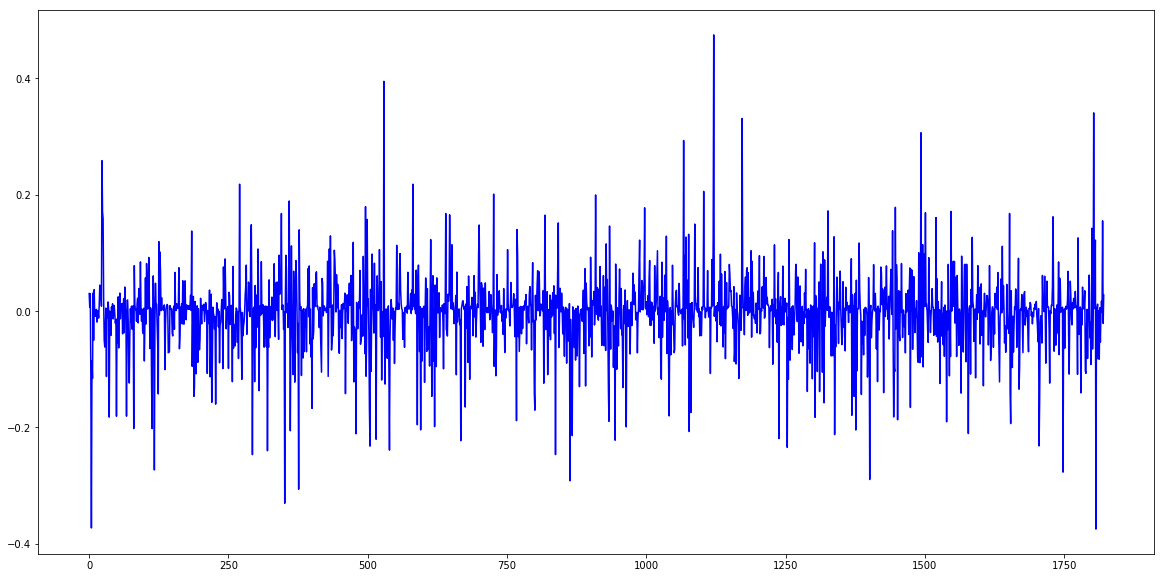

In [36]:
predictions = predictions.reshape(-1)
fig = plt.figure(figsize=(20,10))
plt.plot(predictions - y_test, 'b');